# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для компании. Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

## Подготовка данных

Импортируем нужные для работы библиотеки

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score

Изучим файлы

In [63]:
try:
    test_df = pd.read_csv(r"C:\Users\User\Gold\gold_recovery_test_new.csv")
    train_df = pd.read_csv(r"C:\Users\User\Gold\gold_recovery_train_new.csv")
    full_df = pd.read_csv(r"C:\Users\User\Gold\gold_recovery_full_new.csv")
except:
    test_df = pd.read_csv('/datasets/gold_recovery_test_new.csv')
    train_df = pd.read_csv('/datasets/gold_recovery_train_new.csv')
    full_df = pd.read_csv('/datasets/gold_recovery_full_new.csv')

display(test_df.info())
display(train_df.info())
display(full_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


None

Заметили, что в тестовой выборке нет некоторых столбцов (признаков), которые есть в остальных выборках. <p>
Почти во всех столбцах (признаках) есть пропуски, но их количество незначительно. <p>

Проверим правильность расчета эффективности обогащения:

In [64]:
def efficiency(i):
    conc = i['rougher.output.concentrate_au']
    tail = i['rougher.output.tail_au']
    feed = i['rougher.input.feed_au']
    rec = (conc * (feed - tail)) / (feed * (conc - tail)) * 100
    return rec

train_df['efficiency'] = train_df.apply(efficiency, axis=1)

if (train_df['efficiency'].mean() == train_df['rougher.output.recovery'].mean()) == True:
    print('Расчёт верен')
else:
    print('Расчёт неверен')

Расчёт верен


Найдем MAE между нашими расчетами и значением признака:

In [65]:
mean_absolute_error(train_df['efficiency'], train_df['rougher.output.recovery'])

9.73512347450521e-15

In [66]:
train_df = train_df.drop(['efficiency'], axis=1)

Значение MAE незначительное, что подтверждает наш вывод.

Проанализируем признаки, недоступные в тестовой выборке: 

In [67]:
samples_diff = set(train_df.columns)-set(test_df.columns)
samples_diff

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

В тестовой выборке, видимо, отсутствуют параметры, которые определены до начала технологического процесса: <p>
 - Характеристики содержания различных металлов
 - Параметры выходных продуктов
 - Параметры вторичных стадий обогащения
 - Параметры очистки металлов на различных стадиях

Предобработка данных: <p>
В условии сказано, что индексация просиходит по дате и времени, исходя из этой информации, можем заполнить пропуски значениями из предыдущих строк. 

In [68]:
train_df = train_df.fillna(method='ffill')
test_df = test_df.fillna(method='ffill')
full_df = full_df.fillna(method='ffill')

train_df.isna().sum()
test_df.isna().sum()
full_df.isna().sum()

date                                          0
final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_sol                  0
final.output.concentrate_au                   0
                                             ..
secondary_cleaner.state.floatbank5_a_level    0
secondary_cleaner.state.floatbank5_b_air      0
secondary_cleaner.state.floatbank5_b_level    0
secondary_cleaner.state.floatbank6_a_air      0
secondary_cleaner.state.floatbank6_a_level    0
Length: 87, dtype: int64

Проверим выборки на наличие дубликатов:

In [69]:
print(train_df.duplicated().sum())
print(test_df.duplicated().sum())
print(full_df.duplicated().sum())

0
0
0


Вывод по этапу: <p>
 - Подтвердили правильность расчета эффективности обогащения
 - Проанализировали признаки, недоступные в тестовой выборке
 - Провели предобработку данных: <p>
    - Обнаружили недостающие данные и заполнили их соседними значениями
    - Дубликатов не обнаружили
    - Выборка пришла нам с названиями столбцов в нижнем и змеином регистре, поэтому их обрабатывать не пришлось

## Анализ данных

### Изменение концентрации металлов на разных этапах очистки

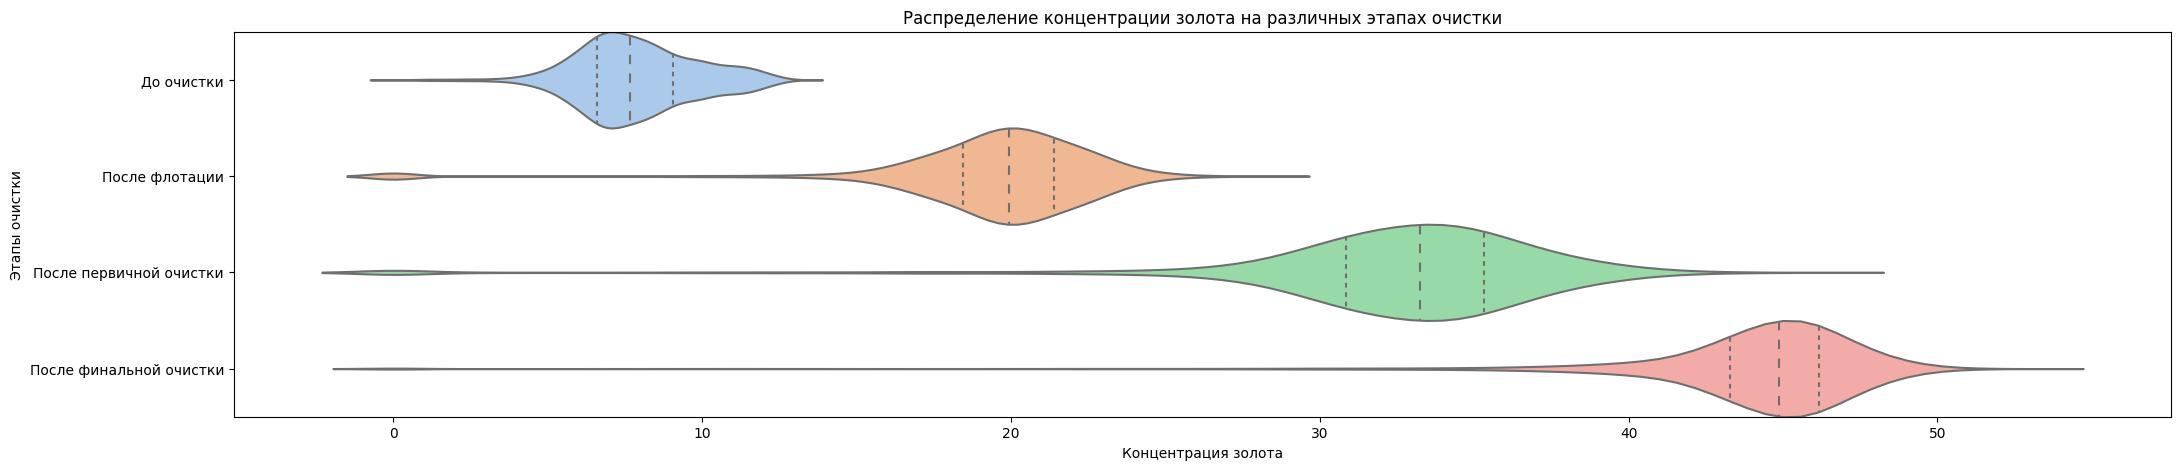

In [70]:
df_au = train_df[['rougher.input.feed_au', 'rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au']]
labels_au = ['До очистки', 'После флотации', 'После первичной очистки', 'После финальной очистки']

sns.violinplot(data=df_au, orient='h', palette='pastel', scale='width', bw=.2, width=1, inner='quartile')

plt.title('Распределение концентрации золота на различных этапах очистки')
plt.xlabel('Концентрация золота')
plt.ylabel('Этапы очистки')
plt.yticks(np.arange(4), labels_au)
plt.show()


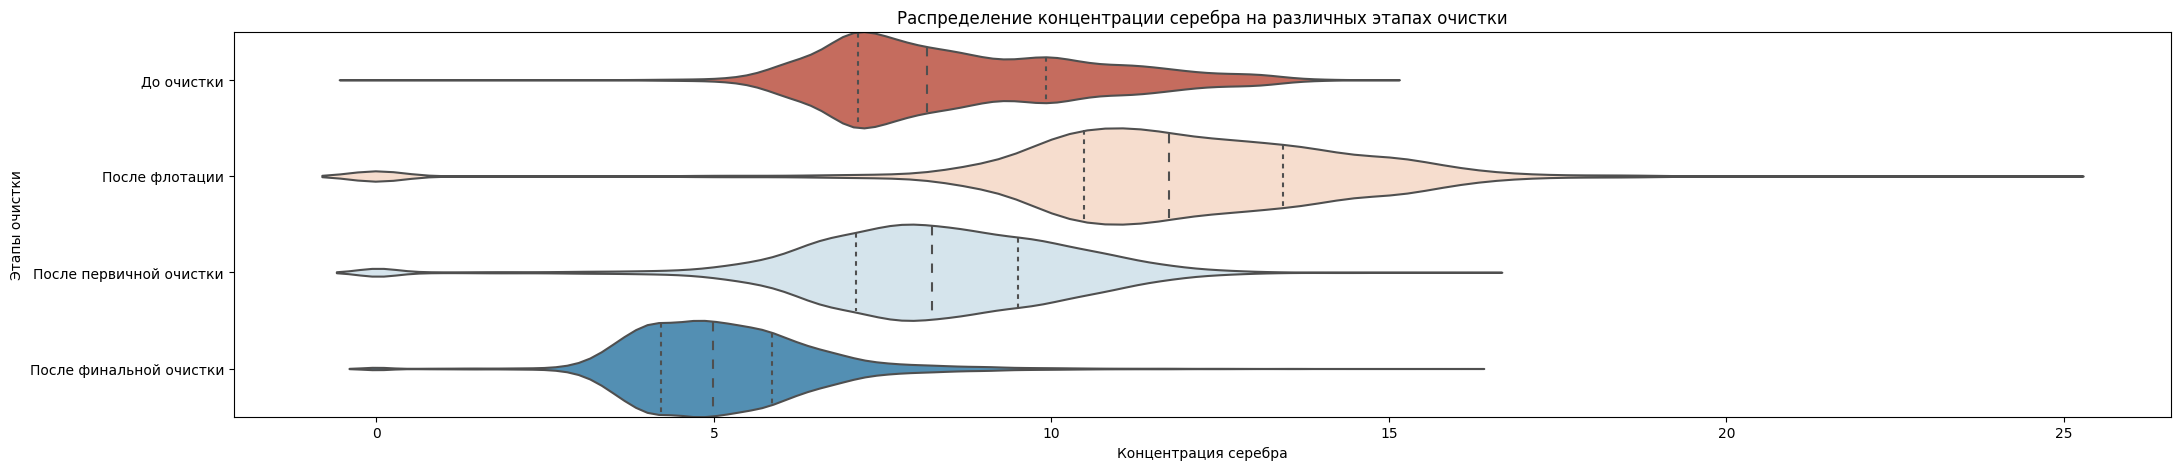

In [71]:
df_ag = train_df[['rougher.input.feed_ag', 'rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag']]
labels_ag = ['До очистки', 'После флотации', 'После первичной очистки', 'После финальной очистки']

sns.violinplot(data=df_ag, orient='h', palette='RdBu', scale='width', width=1, inner='quartile')

plt.title('Распределение концентрации серебра на различных этапах очистки')
plt.xlabel('Концентрация серебра')
plt.ylabel('Этапы очистки')
plt.yticks(np.arange(4), labels_ag)
plt.show()

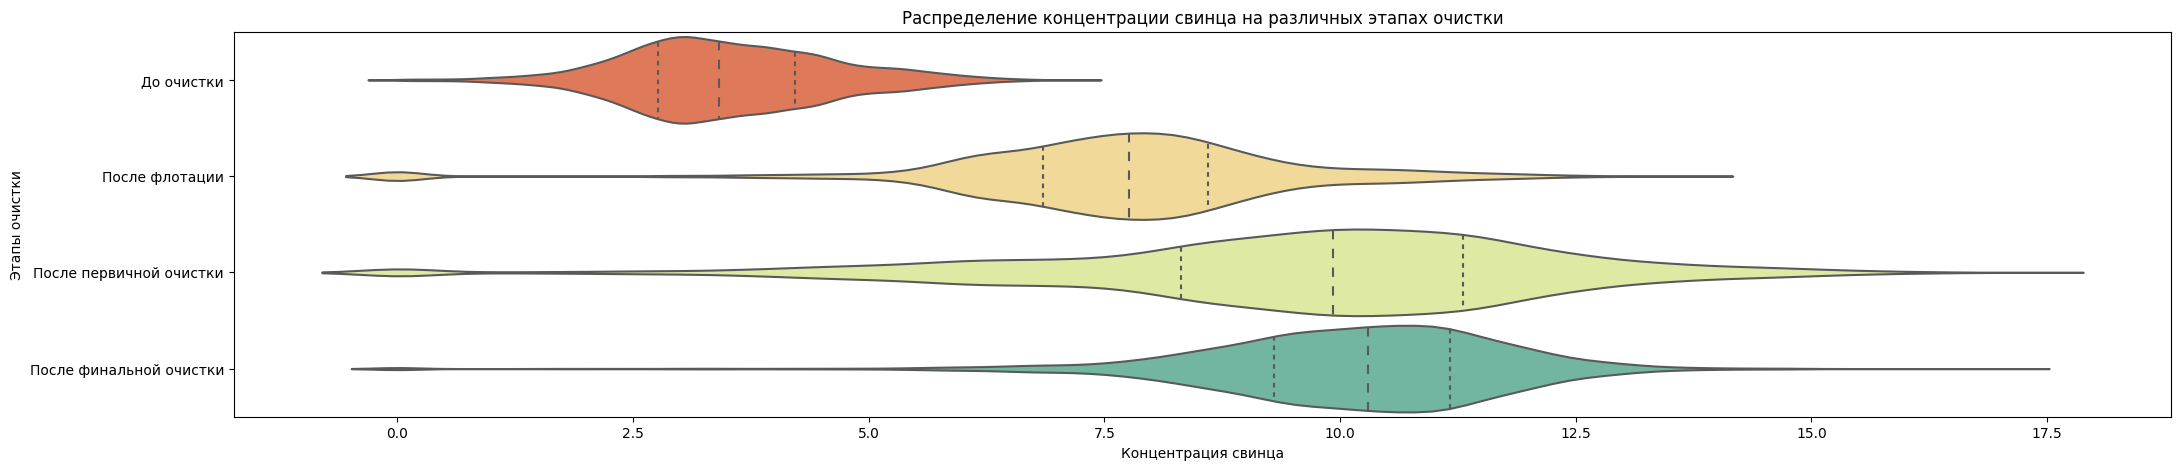

In [72]:
df_pb = train_df[['rougher.input.feed_pb', 'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']]
labels_pb = ['До очистки', 'После флотации', 'После первичной очистки', 'После финальной очистки']

sns.violinplot(data=df_pb, orient='h', scale='width', width=0.9, inner='quartile', palette='Spectral')
plt.title('Распределение концентрации свинца на различных этапах очистки')
plt.xlabel('Концентрация свинца')
plt.ylabel('Этапы очистки')
plt.yticks(np.arange(4), labels_pb)
plt.show()

<b> Выводы по подразделу: </b> <p>
 - Концентрация золота на последнем этапе повышается почти в 5 раз, в сравнении с сырьем. Судя по графику, концентрация повышается планомерно на каждом этапе, следовательно, процесс очистки сырья выстроен эффективно.
 - Концентрация серебра повышается на этапе флотации, далее - снижается. После финальной очистки концентрация ниже, чем до очистки.
 - Концентрация свинца значительно (в 3 раза) повышается на этапе флотации, незначительно - на этапе первичной очистки. Далее почти не изменяется.

### Сравнение распределения размеров гранул сырья

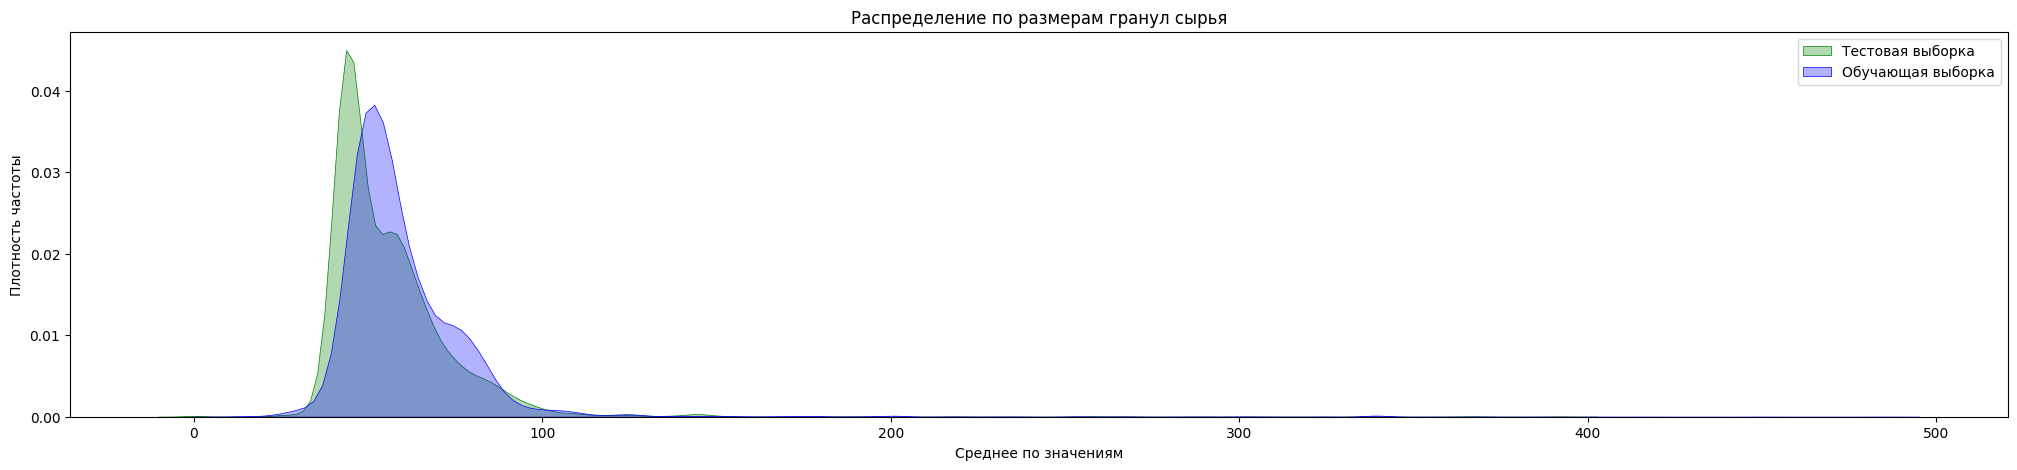

In [73]:
sns.kdeplot(test_df['rougher.input.feed_size'], color='g', fill=True, common_norm=False, palette="crest", alpha=.3, linewidth=.5).set(xlabel='Среднее по значениям', ylabel='Плотность частоты', title='Распределение по размерам гранул сырья')
sns.kdeplot(train_df['rougher.input.feed_size'], color='b', fill=True, common_norm=False, palette="crest", alpha=.3, linewidth=.5).set(xlabel='Среднее по значениям', ylabel='Плотность частоты', title='Распределение по размерам гранул сырья')
plt.legend(['Тестовая выборка', 'Обучающая выборка'])
rcParams['figure.figsize'] = 25, 5

Оба распределения можно интерпретировать как нормальные со смещением влево. 

### Определение суммарной концентрации веществ на разных стадиях

In [74]:
sum_df = pd.DataFrame()
sum_df['rougher.input.feed_sum'] = train_df['rougher.input.feed_ag'] + train_df['rougher.input.feed_pb'] + train_df['rougher.input.feed_au'] + train_df['rougher.input.feed_sol']
sum_df['rougher.output.concentrate_sum'] = train_df['rougher.output.concentrate_ag'] + train_df['rougher.output.concentrate_pb'] + train_df['rougher.output.concentrate_au'] + train_df['rougher.output.concentrate_sol']
sum_df['final.output.concentrate_sum'] = train_df['final.output.concentrate_ag'] + train_df['final.output.concentrate_pb'] + train_df['final.output.concentrate_au'] + train_df['final.output.concentrate_sol']

 Заметка: В суммарную концентрацию веществ также добавлены значения признака Sol (возможно, растворы или растворители для прочих веществ, которые участвуют в процессе очистки).

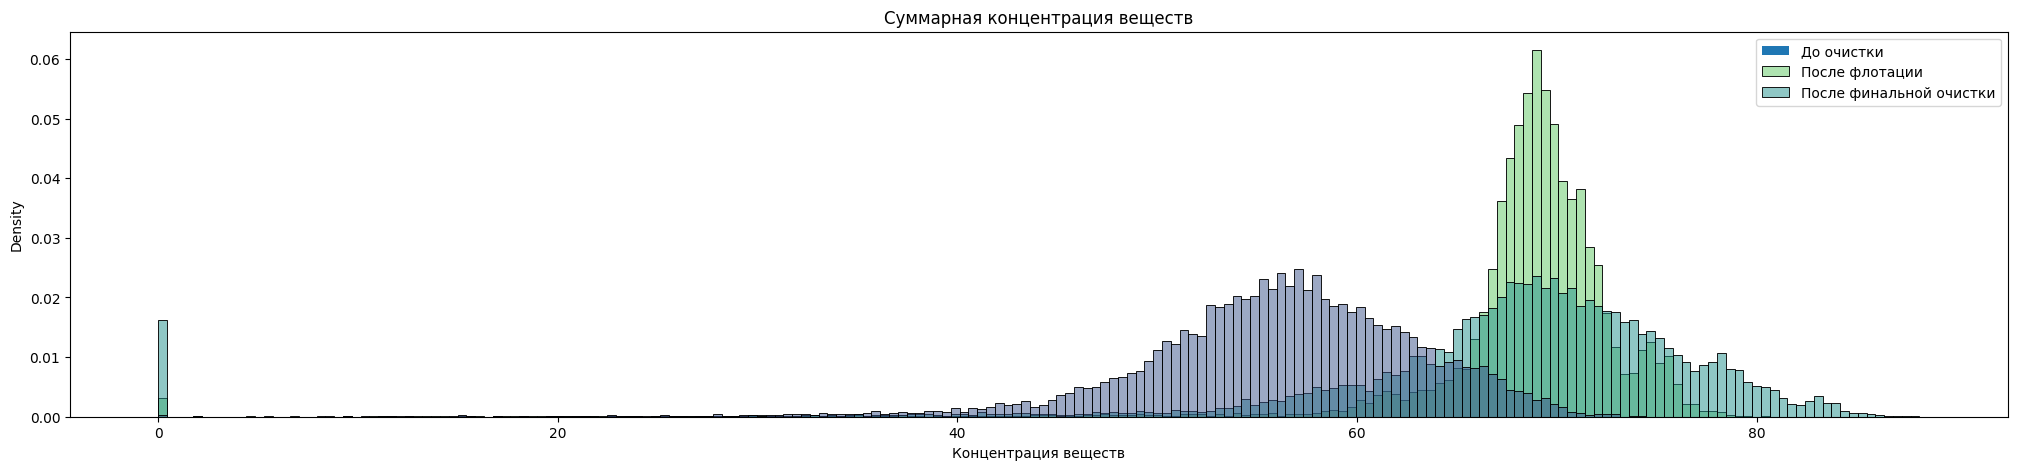

In [75]:
sns.histplot(sum_df, bins=200, kde=False, palette='viridis', stat='density').set(xlabel='Концентрация веществ', title='Суммарная концентрация веществ')
plt.legend(['До очистки', 'После флотации', 'После финальной очистки'])

На графике можно заметить, что суммарная концентрация веществ (определенных в задании) растет с каждым этапом очистки. <p>
Также заметно незначительное количество аномалий в виде нулевых значений. Удалим их из данных, касающихся золота.

In [76]:
train_df[train_df['primary_cleaner.output.concentrate_au'] == 0]['primary_cleaner.output.concentrate_au'].count()

74

In [77]:
train_df = train_df.drop(train_df[train_df['primary_cleaner.output.concentrate_au'] == 0].index)

<b>Вывод по разделу:</b> <p>
 - В процессе очистки, концентрация веществ (Серебра, золота, свинца и раствора/растворителей) растёт и достигает максимума на финальном этапе.
 - Концентрация интересующего нас золота растёт равномерно на каждом этапе.
 - Размер гранул золота в выборках различается незначительно.
 - Были найдены и удалены аномалии в виде нулевых значений.

## Модель

Создадим тестовую выборку, с необходимыми нам признаками.

In [78]:
new_test_df = test_df.merge(full_df[['rougher.output.recovery', 'final.output.recovery', 'date']], on='date', how='left')
new_test_df.drop(['date'], axis=1, inplace=True)
new_test_df.shape

(5290, 54)

Создадим тренировочную выборку без столбцов, которых нет в тестовой.

In [79]:
samples_diff = set(train_df.columns) - set(new_test_df.columns)

new_train_df = train_df.drop(samples_diff, axis=1)
new_train_df.shape

(14075, 54)

Определим признаки, необходимые для обучения модели и создадим выборки для обучения и валидации моделей.

In [80]:
features_train_rougher = new_train_df.filter(regex='^rougher',axis=1).drop(['rougher.output.recovery'], axis=1)
target_train_rougher = new_train_df['rougher.output.recovery']

features_test_rouger = new_test_df.filter(regex='^rougher',axis=1).drop(['rougher.output.recovery'], axis=1)
target_test_rougher = new_test_df['rougher.output.recovery']

features_train_rougher.shape, features_test_rouger.shape, target_train_rougher.shape, target_test_rougher.shape

((14075, 22), (5290, 22), (14075,), (5290,))

In [81]:
features_train_final = new_train_df.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
target_train_final = new_train_df['final.output.recovery']

features_test_final = new_test_df.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
target_test_final = new_test_df['final.output.recovery']

features_train_final.shape, features_test_final.shape, target_train_final.shape, target_test_final.shape

((14075, 52), (5290, 52), (14075,), (5290,))

Создадим функции для вычисления sMAPE и итоговой sMAPE.

In [82]:
def smape (target, predictions):
    return 100/len(target) * np.sum(2 * np.abs(predictions - target) / (np.abs(target) + np.abs(predictions)))

def smape_final(rougher, final):
    return 0.25 * rougher + 0.75 * final

def smape_total(tgt_rougher, pred_rougher, tgt_final, pred_final):
    return 0.25 * smape(tgt_rougher, pred_rougher) + 0.75 * smape(tgt_final, pred_final)

Обучим модели и определим наилучший результат.

In [83]:
model_lr = LinearRegression()
scorer = make_scorer(smape, greater_is_better=False)
rougher_lr = cross_val_score(model_lr, features_train_rougher, target_train_rougher, scoring=scorer, cv=5)
final_lr =  cross_val_score(model_lr, features_train_final, target_train_final, scoring=scorer, cv=5)
print('Итоговая sMape:', smape_final(rougher_lr, final_lr).mean())

Итоговая sMape: -12.25481152441784


In [84]:
for depth in range(1, 30, 3):
    model_dt = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    scorer = make_scorer(smape, greater_is_better=False)
    rougher_dt = cross_val_score(model_dt, features_train_rougher, target_train_rougher, scoring=scorer, cv=5)
    final_dt = cross_val_score(model_dt, features_train_final, target_train_final, scoring=scorer, cv=5)
    best_depth_dt = 0
    best_smape_dt = 0
    if smape_final(rougher_dt, final_dt).mean() < best_smape_dt:
        best_depth_dt = depth
        best_smape_dt = smape_final(rougher_dt, final_dt).mean()
print('Глубина:', best_depth_dt)
print('Итоговая sMAPE:', best_smape_dt)

Глубина: 28
Итоговая sMAPE: -18.351564305370758


In [85]:
#for est in tqdm(range(1, 100, 10)):    
#    for depth in tqdm(range(1, 5, 1)):

model_rf = RandomForestRegressor(random_state=12345, max_depth=4, n_estimators=91, n_jobs=-1)
scorer = make_scorer(smape, greater_is_better=False)
rougher_rf = cross_val_score(model_rf, features_train_rougher, target_train_rougher, scoring=scorer, cv=5)
final_rf = cross_val_score(model_rf, features_train_final, target_train_final, scoring=scorer, cv=5)
best_depth_rf = 4
best_smape_rf = 0
best_est_rf = 91
if smape_final(rougher_rf, final_rf).mean() < best_smape_rf:
    best_depth_rf = best_depth_rf
    best_smape_rf = smape_final(rougher_rf, final_rf).mean()
    best_est_rf = best_est_rf
print('Глубина:', best_depth_rf)
print('Итоговая sMAPE:', best_smape_rf)
print('Количество деревьев:', best_est_rf)

Глубина: 4
Итоговая sMAPE: -10.528423339239128
Количество деревьев: 91


In [86]:
model_rf_rougher = RandomForestRegressor(random_state=12345, max_depth=4, n_estimators=91, n_jobs=-1)
model_rf_rougher.fit(features_train_rougher, target_train_rougher)
predictions_lr_rougher = model_rf_rougher.predict(features_test_rouger)

model_rf_final = RandomForestRegressor(random_state=12345, max_depth=4, n_estimators=91, n_jobs=-1)
model_rf_final.fit(features_train_final, target_train_final)
predictions_lr_final = model_rf_final.predict(features_test_final)

print('Итоговая sMAPE для случайного леса:', smape_total(target_test_rougher, predictions_lr_rougher, target_test_final, predictions_lr_final).mean())

Итоговая sMAPE для случайного леса: 9.474996374392658


Лучшей моделью оказалась модель случайного леса. Проверили её на тестовой выборке, применив данный гиперпараметр.

Для проверки модели на адекватность, сравним нашу модель с константной (дамми) моделью.

In [87]:
dummy_rougher = DummyRegressor(strategy='mean')
dummy_final = DummyRegressor(strategy='mean')

dummy_rougher = dummy_rougher.fit(features_train_rougher, target_train_rougher)
predictions_rougher = dummy_rougher.predict(features_test_rouger)

dummy_final = dummy_final.fit(features_train_final, target_train_final)
predictions_final = dummy_final.predict(features_test_final)

print('Итоговая sMAPE:', smape_total(target_test_rougher, predictions_rougher, target_test_final, predictions_final).mean())

Итоговая sMAPE: 10.292328921967524


Посмотрим на результаты сравнения sMAPE нашей модели с константной моделью.

In [88]:
smape_table = pd.DataFrame({'smape': [smape_total(target_test_rougher, predictions_rougher, target_test_final, predictions_final).mean(),
                                        smape_total(target_test_rougher, predictions_lr_rougher, target_test_final, predictions_lr_final).mean()]},
                            index=['dummy', 'random_forest'])
smape_table

,smape
dummy,10.292329
random_forest,9.474996


Наша модель показала результат лучше (с меньшим значением ошибки sMAPE), чем константная модель. Следовательно, модель прошла проверку на адекватность. <p>

<b> Итоговый вывод: </b> <p>
 - В рамках исследования, была проведена предобработка данных, проведен анализ размеров гранул сырья и проведен анализ концентрации металлов на разных этапах очистки.
 - Также были обучены модели для предсказания концентрации золота на различных этапах очистки.
 - Из рассмотренных моделей лучше всего в данном исследовании себя показала модель случайного леса.